<h2>Python for Data Science 
    Final Project</h2>

<h3>Machine Learning to Identify Fraud in the Enron Corpus</h3>

**1. Context**

In late 2001, Enron, an American energy company, filed for bankruptcy after one of the largest financial scandals in corporate history. After the company's collapse, over 600,000 emails generated by 158 Enron employees - now known as the Enron Corpus - were acquired by the Federal Energy Regulatory Commission during its investigation. The data was then uploaded online, and since then, a number of people and organizations have graciously prepared, cleaned and organized the dataset that is available to the public today (a few years later, financial data of top Enron executives were released following their trial).

**2. Project** 

The aim of this project is to apply machine learning techniques to build a predictive model that identifies Enron employees that may have committed fraud based on their financial and email data.<br>
**The objective is to get a precision and recall score of at least 0.42** 

In [1]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

<h3>Task 1: Select what features we'll use</h3><br>
</br>Features of this dataset fall into three major types, namely financial features, email features and POI labels as the target feature.

In [2]:


target_label = 'poi'

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

In [3]:
print(features_list)

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']


In [4]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
### 1.1.0 Explore csv file 
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

In [5]:
# Data dictionary complete

data_dict

{'METTS MARK': {'salary': 365788,
  'to_messages': 807,
  'deferral_payments': 'NaN',
  'total_payments': 1061827,
  'loan_advances': 'NaN',
  'bonus': 600000,
  'email_address': 'mark.metts@enron.com',
  'restricted_stock_deferred': 'NaN',
  'deferred_income': 'NaN',
  'total_stock_value': 585062,
  'expenses': 94299,
  'from_poi_to_this_person': 38,
  'exercised_stock_options': 'NaN',
  'from_messages': 29,
  'other': 1740,
  'from_this_person_to_poi': 1,
  'poi': False,
  'long_term_incentive': 'NaN',
  'shared_receipt_with_poi': 702,
  'restricted_stock': 585062,
  'director_fees': 'NaN'},
 'BAXTER JOHN C': {'salary': 267102,
  'to_messages': 'NaN',
  'deferral_payments': 1295738,
  'total_payments': 5634343,
  'loan_advances': 'NaN',
  'bonus': 1200000,
  'email_address': 'NaN',
  'restricted_stock_deferred': 'NaN',
  'deferred_income': -1386055,
  'total_stock_value': 10623258,
  'expenses': 11200,
  'from_poi_to_this_person': 'NaN',
  'exercised_stock_options': 6680544,
  'from_

In [6]:
### 1.1.1 Dataset Exploration
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
num_not_poi = (len(data_dict.keys()) - num_poi)
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % num_not_poi)

# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


In [7]:
###1.1.2 Feature Exploration
all_features = data_dict['METTS MARK'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

Each person has 21 features available


In [8]:
### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
email_address: 35
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
from_poi_to_this_person: 60
exercised_stock_options: 44
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
long_term_incentive: 80
shared_receipt_with_poi: 60
restricted_stock: 36
director_fees: 129


<br>**The missing data for financial features (payment, fees and stock) represent 0 and not unknown quantities, as it is shown in [Enron's public data](https://github.com/louisedietrich/Enron-Financial-Dataset).
We will thus in a first place replace all the missing values by 0.**</br> 

<br>**For the features concerning emails (to_messages, from_messages, from_poi_to_this_person, from_this_person_to_poi, shared_receipt_with_poi.), missing values are unknown information. We don't want to drop all those values as we already are working on a rather small dataset and need data to build our models. We will replace the missing information by its average values, depending on the person's profile (i.e. average values for the POI or not POI for each feature).**</br>


In [9]:
# Convert 'NaN' string to zero
for person in data_dict.keys():
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            data_dict[person][feature] = 0

In [10]:
# Data dictionary complete to check if the NaN values are removed

data_dict

{'METTS MARK': {'salary': 365788,
  'to_messages': 807,
  'deferral_payments': 0,
  'total_payments': 1061827,
  'loan_advances': 0,
  'bonus': 600000,
  'email_address': 'mark.metts@enron.com',
  'restricted_stock_deferred': 0,
  'deferred_income': 0,
  'total_stock_value': 585062,
  'expenses': 94299,
  'from_poi_to_this_person': 38,
  'exercised_stock_options': 0,
  'from_messages': 29,
  'other': 1740,
  'from_this_person_to_poi': 1,
  'poi': False,
  'long_term_incentive': 0,
  'shared_receipt_with_poi': 702,
  'restricted_stock': 585062,
  'director_fees': 0},
 'BAXTER JOHN C': {'salary': 267102,
  'to_messages': 0,
  'deferral_payments': 1295738,
  'total_payments': 5634343,
  'loan_advances': 0,
  'bonus': 1200000,
  'email_address': 0,
  'restricted_stock_deferred': 0,
  'deferred_income': -1386055,
  'total_stock_value': 10623258,
  'expenses': 11200,
  'from_poi_to_this_person': 0,
  'exercised_stock_options': 6680544,
  'from_messages': 0,
  'other': 2660303,
  'from_this_p

**Now that all NaN values are replaced by 0, we will focus on the 5 variables explaining the interaction with a poi or not poi:**</br>
<br>to_messages, from_messages, from_poi_to_this_person, from_this_person_to_poi, shared_receipt_with_poi.</br>
<br>This email data is meaningful information for our prediction of wether an employee will be a POI or not and we will replace, for each of this features, the previously missing values with the mean of the variable grouped by POI profile.

In [11]:
# Replace to_messages = 0 (so previously missing) with the average of to_messages for poi or the average of to_messages 
# for not poi, depending on the category of the person
sum_to_messages_poi = 0
sum_to_messages_not_poi = 0
for person in data_dict.keys():
    if data_dict[person]['poi'] == True:
        sum_to_messages_poi += data_dict[person]['to_messages']
    else:
        sum_to_messages_not_poi += data_dict[person]['to_messages']

for person in data_dict.keys():
    if data_dict[person]['to_messages'] == 0:
        if data_dict[person]['poi'] == True:
            data_dict[person]['to_messages'] = sum_to_messages_poi/num_poi
        else:
            data_dict[person]['to_messages'] = sum_to_messages_not_poi/num_not_poi

In [12]:
# Replace from_messages = 0 (so previously missing) with the average of from_messages for poi or the average of from_messages 
# for not poi, depending on the category of the person
sum_from_messages_poi = 0
sum_from_messages_not_poi = 0
for person in data_dict.keys():
    if data_dict[person]['poi'] == True:
        sum_from_messages_poi += data_dict[person]['from_messages']
    else:
        sum_from_messages_not_poi += data_dict[person]['from_messages']

for person in data_dict.keys():
    if data_dict[person]['from_messages'] == 0:
        if data_dict[person]['poi'] == True:
            data_dict[person]['from_messages'] = sum_to_messages_poi/num_poi
        else:
            data_dict[person]['from_messages'] = sum_to_messages_not_poi/num_not_poi

In [13]:
# Replace from_poi_to_this_person = 0 (so previously missing) with the average of from_poi_to_this_person for poi or the average of from_poi_to_this_person 
# for not poi, depending on the category of the person
sum_from_poi_to_this_person_poi = 0
sum_from_poi_to_this_person_not_poi = 0
for person in data_dict.keys():
    if data_dict[person]['poi'] == True:
        sum_from_poi_to_this_person_poi += data_dict[person]['from_poi_to_this_person']
    else:
        sum_from_poi_to_this_person_not_poi += data_dict[person]['from_poi_to_this_person']

for person in data_dict.keys():
    if data_dict[person]['from_poi_to_this_person'] == 0:
        if data_dict[person]['poi'] == True:
            data_dict[person]['from_poi_to_this_person'] = sum_from_poi_to_this_person_poi/num_poi
        else:
            data_dict[person]['from_poi_to_this_person'] = sum_from_poi_to_this_person_not_poi/num_not_poi

In [14]:
# Replace from_this_person_to_poi = 0 (so previously missing) with the average of from_this_person_to_poi for poi or the average of from_this_person_to_poi 
# for not poi, depending on the category of the person
sum_from_this_person_to_poi_poi = 0
sum_from_this_person_to_poi_not_poi = 0
for person in data_dict.keys():
    if data_dict[person]['poi'] == True:
        sum_from_this_person_to_poi_poi += data_dict[person]['from_this_person_to_poi']
    else:
        sum_from_this_person_to_poi_not_poi += data_dict[person]['from_this_person_to_poi']

for person in data_dict.keys():
    if data_dict[person]['from_this_person_to_poi'] == 0:
        if data_dict[person]['poi'] == True:
            data_dict[person]['from_this_person_to_poi'] = sum_from_this_person_to_poi_poi/num_poi
        else:
            data_dict[person]['from_this_person_to_poi'] = sum_from_this_person_to_poi_not_poi/num_not_poi

In [15]:
# Replace shared_receipt_with_poi = 0 (so previously missing) with the average of shared_receipt_with_poi for poi or the average of shared_receipt_with_poi 
# for not poi, depending on the category of the person
sum_shared_receipt_with_poi_poi = 0
sum_shared_receipt_with_poi_not_poi = 0
for person in data_dict.keys():
    if data_dict[person]['poi'] == True:
        sum_shared_receipt_with_poi_poi += data_dict[person]['shared_receipt_with_poi']
    else:
        sum_shared_receipt_with_poi_not_poi += data_dict[person]['shared_receipt_with_poi']

for person in data_dict.keys():
    if data_dict[person]['shared_receipt_with_poi'] == 0:
        if data_dict[person]['poi'] == True:
            data_dict[person]['shared_receipt_with_poi'] = sum_shared_receipt_with_poi_poi/num_poi
        else:
            data_dict[person]['shared_receipt_with_poi'] = sum_shared_receipt_with_poi_not_poi/num_not_poi

In [16]:
#Checking if the data has been well modified
import pandas as pd
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807.0,0,1061827,0,600000,mark.metts@enron.com,0,0,585062,...,38.00000,0,29.0,1740,1.00000,False,0,702.000000,585062,0
BAXTER JOHN C,267102,1129.0,1295738,5634343,0,1200000,0,0,-1386055,10623258,...,32.90625,6680544,1129.0,2660303,20.40625,False,1586055,595.421875,3942714,0
ELLIOTT STEVEN,170941,1129.0,0,211725,0,350000,steven.elliott@enron.com,0,-400729,6678735,...,32.90625,4890344,1129.0,12961,20.40625,False,0,595.421875,1788391,0
CORDES WILLIAM R,0,764.0,0,0,0,0,bill.cordes@enron.com,0,0,1038185,...,10.00000,651850,12.0,0,20.40625,False,0,58.000000,386335,0
HANNON KEVIN P,243293,1045.0,0,288682,0,1500000,kevin.hannon@enron.com,0,-3117011,6391065,...,32.00000,5538001,32.0,11350,21.00000,True,1617011,1035.000000,853064,0


<h3>Task 2: Remove outliers</h3>

In [17]:


def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

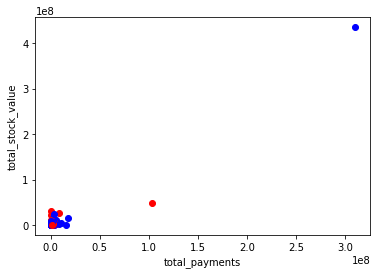

None


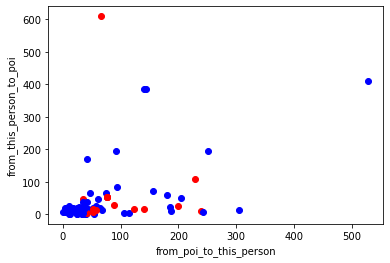

None


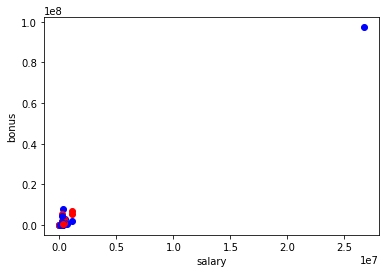

None


{'salary': 26704229,
 'to_messages': 1129.0,
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 0,
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 32.90625,
 'exercised_stock_options': 311764000,
 'from_messages': 1129.0,
 'other': 42667589,
 'from_this_person_to_poi': 20.40625,
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 595.421875,
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [18]:
# 2.1 Visualise outliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )

**The "total row" value displayed in the outliers plots is taken off, as it is not relevant information and will distort our resuls.**

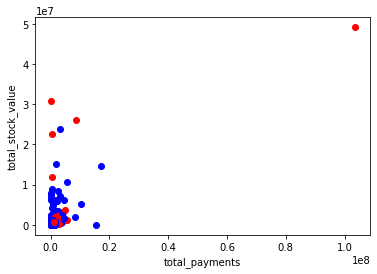

None


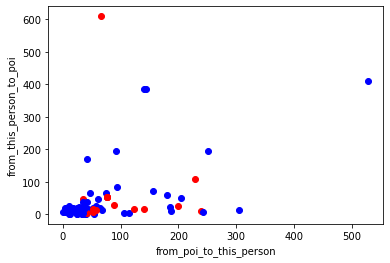

None


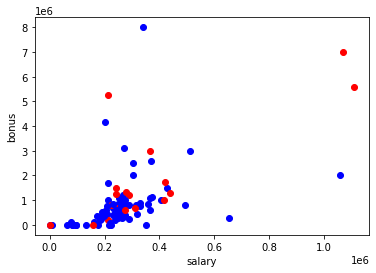

None


In [19]:
# Visualise without otuliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))

In [20]:
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))

Total number of data points: 145


**Considering the visualization of our outliers, we try to identify the people we could remove from our model according to their high salary and/or bonus, and that have not been identified as POI**

In [21]:
for person in data_dict.keys():
        if (data_dict[person]['salary'] > 500000 or (data_dict[person]['bonus'] > 1100000 and data_dict[person]['salary'] > 260000)) and data_dict[person]['poi'] == False:
            print(person)

BAXTER JOHN C
MCMAHON JEFFREY
HAEDICKE MARK E
KITCHEN LOUISE
SHANKMAN JEFFREY A
LAVORATO JOHN J
SHERRIFF JOHN R
WHALLEY LAWRENCE G
FALLON JAMES B
PICKERING MARK R
FREVERT MARK A


From this list of people with very high salaries and/or bonuses but that are not identified as POI, we decided to remove from our study four of them who had upper-level executive positions and are not representative of the average Enron employee: 
* FREVERT MARK A
* LAVORATO JOHN J
* WHALLEY LAWRENCE G
* BAXTER JOHN C

<br>As we saw a step above, we also will remove the TOTAL row from our dataset. </br>

Two other already identified outliers are "THE TRAVEL AGENCY IN THE PARK" that is not a person, along with "LOCKHART EUGENE E" who has no feature values.


In [22]:
# 2.2 Function to remove outliers
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL','THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E', 'FREVERT MARK A', 'WHALLEY LAWRENCE G', 'BAXTER JOHN C', 'LAVORATO JOHN J']

remove_outlier(data_dict, outliers)

In [23]:
data_dict.keys()
print('Total number of data points after removing the outliers: %d' % len(data_dict.keys()))

Total number of data points after removing the outliers: 139


<h3>Task 3: Create new feature(s)</h3>

In [24]:

# 3.1 create new copies of dataset for grading
my_dataset = data_dict

## 3.2 add new features to dataset
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 0 or all_messages == 0:
        return 0.
    fraction = poi_messages / all_messages
    return fraction

for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi
    shared_receipt_with_poi = data_point["shared_receipt_with_poi"]
    fraction_shared_poi = compute_fraction(shared_receipt_with_poi,to_messages)
    data_point["fraction_shared_poi"] = fraction_shared_poi
    bonus = data_point["bonus"]
    salary = data_point["salary"]
    total_payments = data_point["total_payments"]
    bonus_to_salary = compute_fraction(bonus, salary)
    data_point["bonus_to_salary"] = bonus_to_salary
    bonus_to_total = compute_fraction(bonus, total_payments)
    data_point["bonus_to_total"] = bonus_to_total

In [25]:
# 3.3 create new copies of feature list for grading
my_feature_list = features_list + ['fraction_to_poi', 'fraction_from_poi', 'fraction_shared_poi']

In [26]:
my_feature_list

['poi',
 'bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'exercised_stock_options',
 'expenses',
 'loan_advances',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'total_payments',
 'total_stock_value',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'to_messages',
 'fraction_to_poi',
 'fraction_from_poi',
 'fraction_shared_poi']

**After computing our model with a different number of features, we found out that 4 was the number of variables giving the best results with our data. We used the function with selectKBest to get the list of the 4 highest scoring features.**

In [27]:
# 3.4 get K-best features
num_features = 4

In [28]:
# 3.5 function using SelectKBest
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features


best_features = get_k_best(my_dataset, my_feature_list, num_features)

my_feature_list = [target_label] + list(set(best_features.keys()))

[35.7816913   0.06233576 16.95719491  2.20445373 26.5605672   6.27032312
  7.00482086 12.56239963  7.79759949 10.37309462  0.06764556 25.10415132
  9.53332413 26.46587154  0.30567116 15.2720836   3.47344864 18.28791085
  2.28927786  0.24257597  0.07157541 16.00167138]
4 best features: dict_keys(['bonus', 'exercised_stock_options', 'total_stock_value', 'salary'])



In [29]:
# 3.6 print features
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

4 selected features: ['total_stock_value', 'exercised_stock_options', 'bonus', 'salary']



In [30]:
# 3.7 extract the features specified in features_list
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

In [31]:
# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

<h3>Task 4: Using algorithm</h3>

In [32]:
import warnings 
warnings.filterwarnings("ignore")


###4.1  Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

###4.2  Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

###4.3  K-means Clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)


###4.4 Support Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

###4.5 Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)


###4.6 Gradient Boosting Classifier
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)

###4.7 evaluate function
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)


### 4.8 Evaluate all functions
evaluate_clf(g_clf, features, labels)
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
evaluate_clf(rf_clf, features, labels)
evaluate_clf(gb_clf, features, labels)

### Select Logistic Regression as final algorithm
clf = l_clf

# dump your classifier, dataset and features_list so
# anyone can run/check your results

pickle.dump(clf, open("../final_project/my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))


GaussianNB()

Processing....................................................................................................done.

precision: 0.500300505050505
recall:    0.36895656565656565
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1e-08, multi_class='ovr', random_state=42,
                                    solver='liblinear', tol=0.001))])

Processing....................................................................................................done.

precision: 0.573896028971029
recall:    0.34958174603174597
KMeans(n_clusters=2, tol=0.001)

Processing....................................................................................................done.

precision: 0.322760586811512
recall:    0.3449353896103896
SVC(C=1000, class_weight='balanced', gamma=0.0001, random_state=42)

Processing....................................................................................................done.

precisio

**We decided to poursue our classification with the logistic regression as it presented the best precision and recall metrics for our data.**

<h3>Task 5: Tune your classifier to achieve better than .42 precision and recall using the testing script</h3>

In [33]:
### Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

<h5>Parameter tuning & optimization with GridSearchCV</h5>
 
In order to find the best parameters for our logistic regression we used the GridSearchCV algorithm, which also employs cross validation with the StratifiedKFolds cross-validator.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

#pipe = Pipeline([('classifier' , LogisticRegression())])
pipe = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = np.logspace(-4, 4, 20)
n_features = np.arange(1, len(features_list))
param_grid = {
    'solver' : solvers,
    'penalty' : penalty,
    'C' : c_values
}
cv = StratifiedKFold(n_splits=10)

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score' : make_scorer(f1_score)
}

We chose to optimise the F1 score because it conveys the balance between the precision and the recall.

In [35]:
def grid_search_wrapper(refit_score='f1_score'):

    cv = StratifiedKFold(n_splits=10)
    best_clf = GridSearchCV(pipe, param_grid, scoring=scorers, refit=refit_score,
                           cv=cv, return_train_score=True, n_jobs=-1)
    best_clf.fit(features_train, labels_train)

    # make the predictions
    y_pred = best_clf.predict(features_test)

    print('Best params for {}'.format(refit_score))
    print(best_clf.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Logistic Regression optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(labels_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return best_clf

In [36]:
grid_search_clf = grid_search_wrapper(refit_score='f1_score')

Best params for f1_score
{'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}

Confusion matrix of Logistic Regression optimized for f1_score on the test data:
     pred_neg  pred_pos
neg        32         0
pos         5         1


In [37]:
# Assigning best parameters to logistic regression
from sklearn.linear_model import LogisticRegression
l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1.623776739188721, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l1', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

In [38]:
# Updating parameters for logistic regression
clf = l_clf

The code below was used for the tuning of the random forest.
However it should not be used as in the end we chose logistic regression, which has better results.

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

pipe = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score' : make_scorer(f1_score)
}

In [40]:
def grid_search_wrapper(refit_score='f1_score'):

    cv = StratifiedKFold(n_splits=10)
    best_clf = GridSearchCV(pipe, param_grid, scoring=scorers, refit=refit_score,
                           cv=cv, return_train_score=True, n_jobs=-1)
    best_clf.fit(features_train, labels_train)

    # make the predictions
    predict = best_clf.predict(features_test)

    print('Best params for {}'.format(refit_score))
    print(best_clf.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(labels_test, predict),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return best_clf

In [41]:
# Assigning best parameters to random forest

grid_search_clf = grid_search_wrapper(refit_score='f1_score')

Best params for f1_score
{'max_depth': 3, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for f1_score on the test data:
     pred_neg  pred_pos
neg        32         0
pos         5         1


In [42]:
rf_clf = RandomForestClassifier(max_depth = 15 , max_features = 3 , n_estimators = 300, random_state = 42, min_samples_split = 5)

<h3>Task 6: Dump your classifier, dataset, and features_list so anyone can check your results</h3>

In [43]:
###You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [44]:
#TESTER.PY

#!/usr/bin/pickle python -W ignore::DeprecationWarning

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

from sklearn.model_selection import StratifiedShuffleSplit


PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(n_splits=folds, random_state=42)
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv.split(features, labels):
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print ("Warning: Found a predicted label not == 0 or 1.")
                print ("All predictions should take value 0 or 1.")
                print ("Evaluating performance for processed predictions:")
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print (clf)
        print (PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print (RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives))
        print ("")
    except:
        print ("Got a divide by zero when trying out:", clf)
        print ("Precision or recall may be undefined due to a lack of true positive predicitons.")

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "wb") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "wb") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "wb") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "rb") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "rb") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "rb") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1.623776739188721,
                                    class_weight='balanced', multi_class='ovr',
                                    penalty='l1', random_state=42,
                                    solver='liblinear', tol=0.001))])
	Accuracy: 0.82286	Precision: 0.42448	Recall: 0.67450	F1: 0.52105	F2: 0.60342
	Total predictions: 14000	True positives: 1349	False positives: 1829	False negatives:  651	True negatives: 10171



<h2>Conclusions</h2>

The feature selection with SelectKBest resulted in 4 features we would not have intuitively think of: <br>
</br>'exercised_stock_options', 'salary', 'total_stock_value', and 'bonus'.<br>
</br>Indeed what would come naturally to the human mind would be features such as the number of emails from/to a POI received or sent by an Enron employee.<br></br>We can consider that using this algorithm enabled us to achieve higher metrics, in the same way as the GridSearchCV for tuning our logistic regression parameters.  

Our final results have a precision score of 0.424 and a recall score of 0.675. This translates as of all the people identified as POI by our model 42.4% were indeed POI, and that our model identified 67.5% of the POI present in the dataset as such.

Those scores might appear as quite low but we had to consider a relatively small dataset to build our model. Moreover the number of non-POI in the dataset is way higher than the number of POI (128 to 18), which make it more difficult to create a reliable algorithm to detect the POI. 

Another way to improve these scores would be to explore the email data we have not handled, which might lead to the finding of new interesting patterns and more accuracy in our prediction.
